# SAM-Med2D generates predicted object masks based on prompts.

In [47]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import sys

In [48]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


## Example image

In [51]:
image = cv2.imread('data_demo/images/amos_0507_31.png') 
image.shape

AttributeError: 'NoneType' object has no attribute 'shape'

TypeError: Image data of dtype object cannot be converted to float

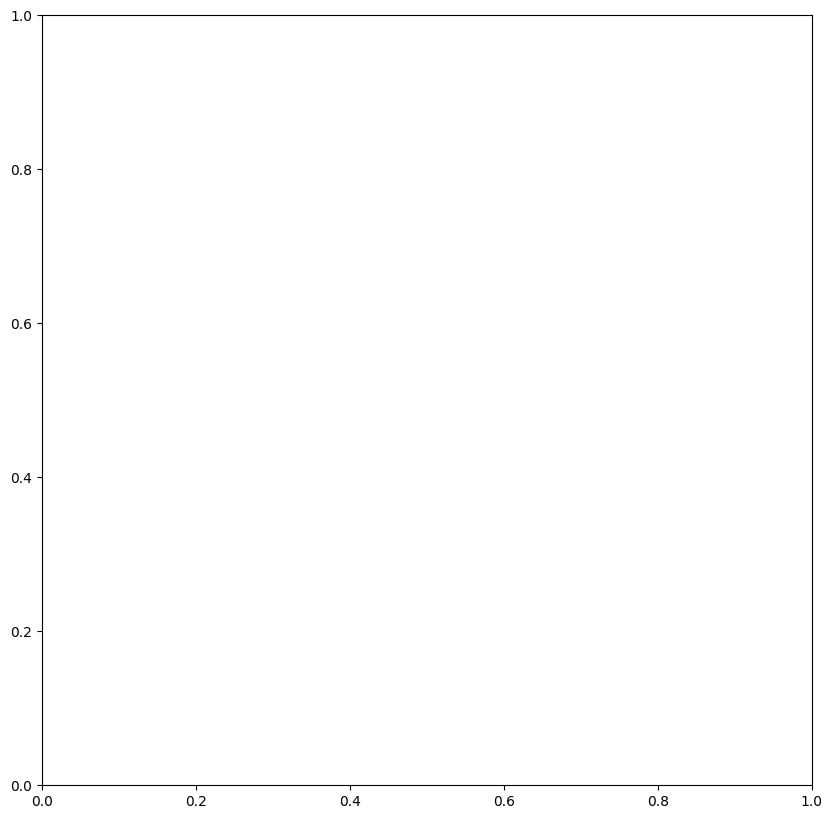

In [50]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.show()

## Load SAM-Med2D model

In [24]:
from segment_anything import sam_model_registry
from segment_anything.predictor_sammed import SammedPredictor
from argparse import Namespace
args = Namespace()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args.image_size = 256
args.encoder_adapter = True
args.sam_checkpoint = "pretrain_model/sam-med2d_b.pth" 
model = sam_model_registry["vit_b"](args).to(device)
predictor = SammedPredictor(model)

True
*******load pretrain_model/sam-med2d_b.pth


Process the image to produce an image embedding by calling `SammedPredictor.set_image`. `SammedPredictor` remembers this embedding and will use it for subsequent mask prediction.

In [25]:
predictor.set_image(image)

## Specifying a specific object with a point

In [30]:
ori_h, ori_w, _ = image.shape
input_point = np.array([[162, 127]]) 
input_label = np.array([1])


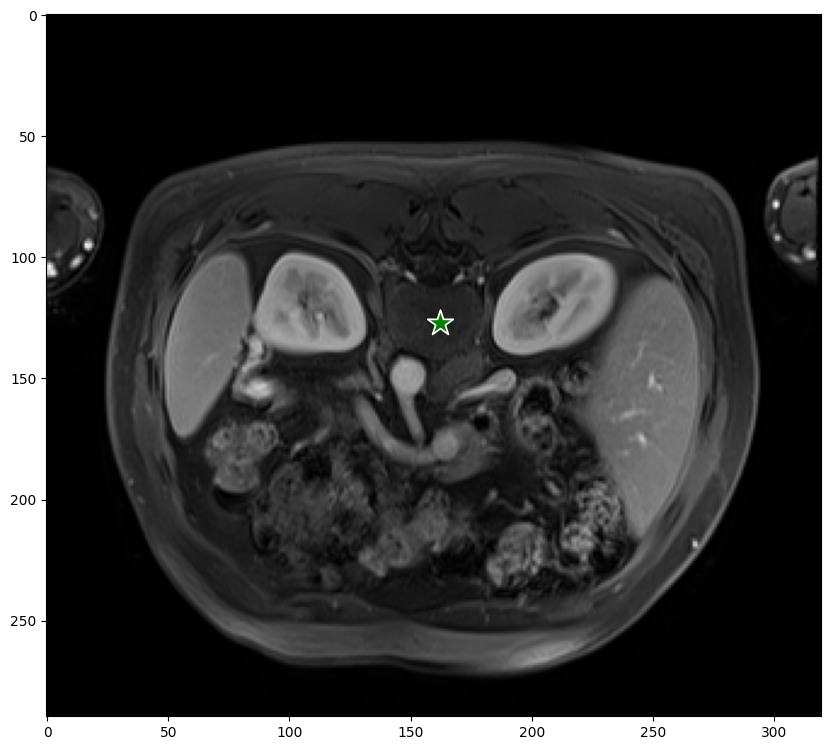

In [31]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

In [32]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
masks.shape  # (number_of_masks) x H x W

(1, 290, 320)

Predict with `SammedPredictor.predict`. The model returns masks, quality predictions for those masks, and low resolution mask logits that can be passed to the next iteration of prediction.

With `multimask_output=True` (the default setting), SAM outputs 3 masks, where `scores` gives the model's own estimation of the quality of these masks. This setting is intended for ambiguous input prompts, and helps the model disambiguate different objects consistent with the prompt. When `False`, it will return a single mask. For ambiguous prompts such as a single point, it is recommended to use `multimask_output=True` even if only a single mask is desired; the best single mask can be chosen by picking the one with the highest score returned in `scores`. This will often result in a better mask.

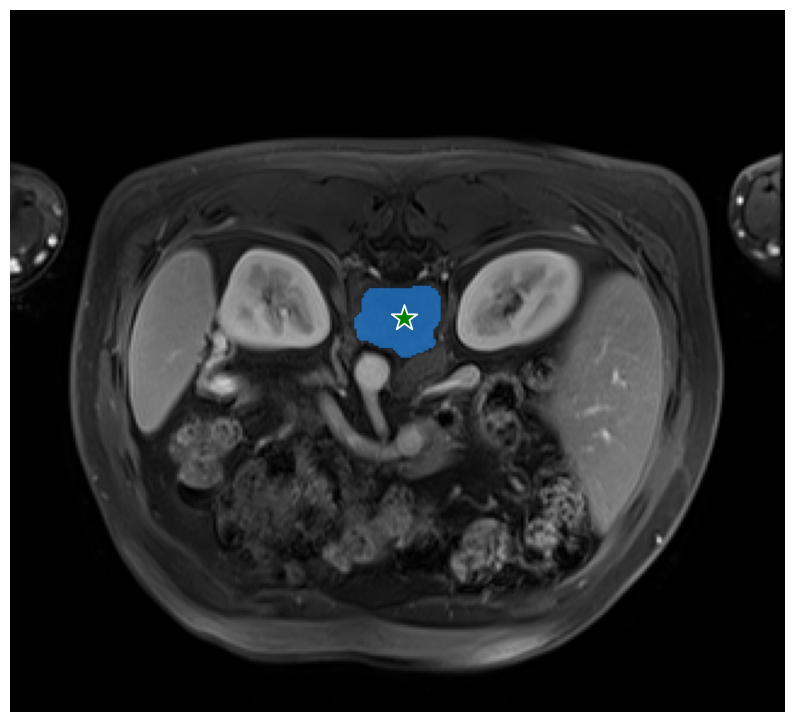

In [34]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()  
  

## Optimizing Segmentation Results by Point Interaction

In [38]:
input_point1 = np.array([[169, 140]]) 
input_label1 = np.array([0])
input_points = np.concatenate((input_point, input_point1))
input_labels = np.concatenate((input_label, input_label1))
mask_inputs = torch.sigmoid(torch.as_tensor(logits, dtype=torch.float, device=device))

In [39]:
masks, scores, logits = predictor.predict(
    point_coords=input_points,
    point_labels=input_labels,
    mask_input = mask_inputs,
    multimask_output=True,
)
masks.shape  # (number_of_masks) x H x W

(1, 290, 320)

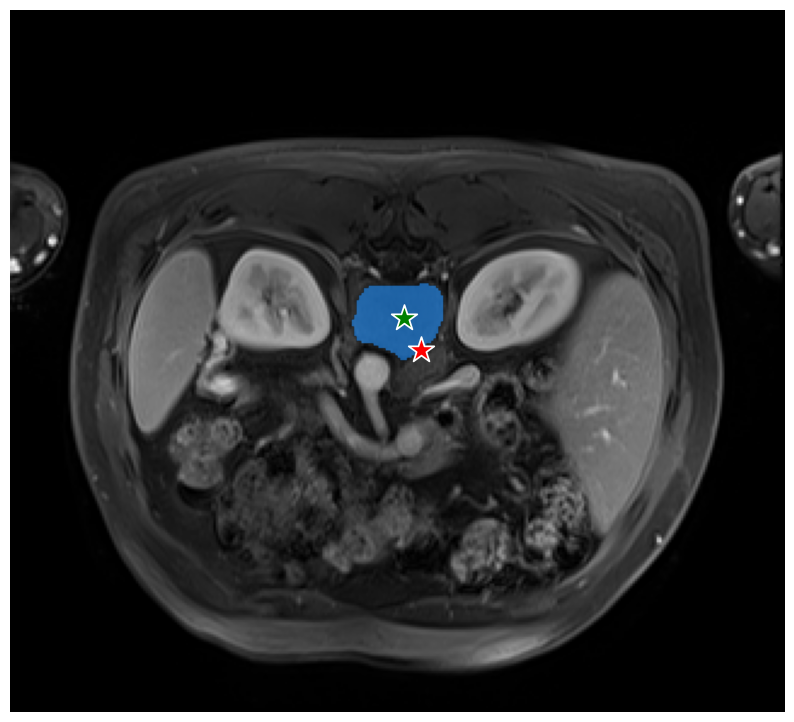

In [40]:

plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_points, input_labels, plt.gca())
plt.axis('off')
plt.show()  

## Specifying a specific object with a bounding box

The model can also take a box as input, provided in xyxy format.

In [41]:
image = cv2.imread('data_demo/images/s0114_111.png.png') 

input_box = np.array([181,94,236,147])

In [42]:
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box,
    multimask_output=True,
)

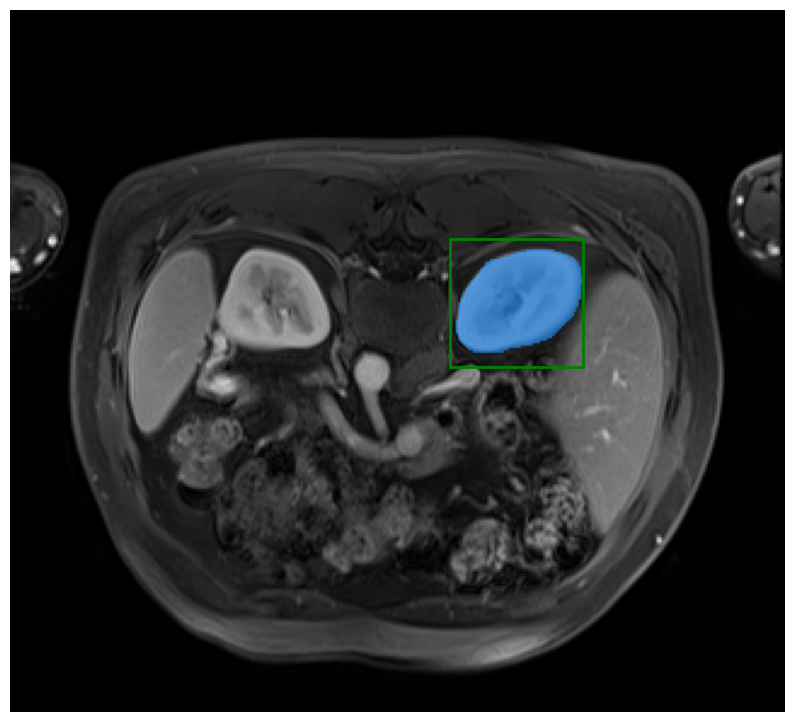

In [43]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

## Multiple bounding box prediction results

In [44]:
input_boxes = torch.tensor([[181,94,236,147],[220,109,276,220]], device=predictor.device)  

In [45]:
transformed_boxes = predictor.apply_boxes_torch(input_boxes, image.shape[:2], (args.image_size, args.image_size))
masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=True,
)
print(transformed_boxes.shape)
print(masks.shape)  # (batch_size) x (num_predicted_masks_per_input) x H x W

torch.Size([2, 4])
torch.Size([2, 1, 290, 320])


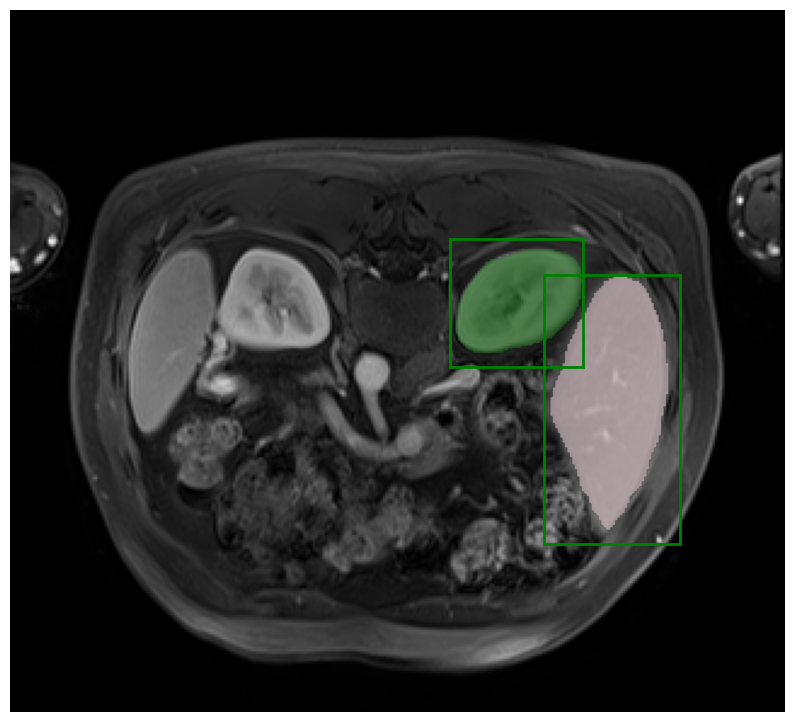

In [46]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box.cpu().numpy(), plt.gca())
plt.axis('off')
plt.show()

